In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggl

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Configuration
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 10
RANDOM_SEED = 42

# Paths (Adjust these based on your specific Kaggle input structure)
FLOWERS_DIR = '/kaggle/input/datasets/alxmamaev/flowers-recognition/flowers' # Update if 'flowers/flowers'
INTEL_DIR = '/kaggle/input/datasets/puneet6060/intel-image-classification/seg_train/seg_train'

2026-02-13 08:36:38.852582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770971799.076675      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770971799.138705      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770971799.677155      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770971799.677193      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770971799.677196      55 computation_placer.cc:177] computation placer alr

Num GPUs Available:  2


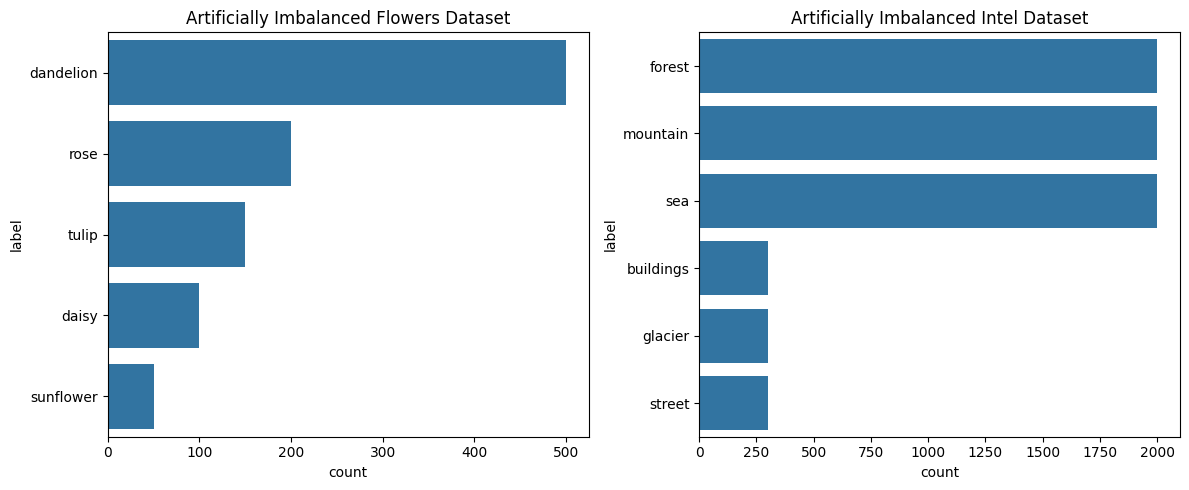

Flowers Samples: 1000
Intel Samples: 6900


In [4]:
def load_and_imbalance_data(dataset_dir, imbalance_counts=None, specific_classes=None):
    """
    Loads images and creates artificial imbalance.
    imbalance_counts: dict {class_name: count_to_keep}
    """
    filepaths = []
    labels = []
    
    classes = sorted(os.listdir(dataset_dir))
    
    for class_name in classes:
        # Skip unrelated files
        if specific_classes and class_name not in specific_classes:
            continue
            
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path): continue
            
        files = os.listdir(class_path)
        
        # Apply Imbalance Logic
        if imbalance_counts and class_name in imbalance_counts:
            limit = imbalance_counts[class_name]
            files = files[:limit] # Truncate to create imbalance
            
        for f in files:
            filepaths.append(os.path.join(class_path, f))
            labels.append(class_name)
            
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    return df

# --- 1. Flower Dataset Imbalance (100:500:200:50:150) ---
# Note: Ensure class names match directory names exactly
flower_imbalance = {
    'daisy': 100,
    'dandelion': 500,
    'rose': 200,
    'sunflower': 50,
    'tulip': 150
}
df_flowers = load_and_imbalance_data(FLOWERS_DIR, imbalance_counts=flower_imbalance)

# --- 2. Intel Dataset Imbalance (Undersample specific classes) ---
intel_imbalance = {
    'buildings': 300, # Undersampled
    'forest': 2000,   # Majority
    'glacier': 300,   # Undersampled
    'mountain': 2000, # Majority
    'sea': 2000,
    'street': 300     # Undersampled
}
df_intel = load_and_imbalance_data(INTEL_DIR, imbalance_counts=intel_imbalance)

# Visualization of Imbalance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(y=df_flowers['label'], order=df_flowers['label'].value_counts().index)
plt.title("Artificially Imbalanced Flowers Dataset")

plt.subplot(1, 2, 2)
sns.countplot(y=df_intel['label'], order=df_intel['label'].value_counts().index)
plt.title("Artificially Imbalanced Intel Dataset")
plt.tight_layout()
plt.show()

print(f"Flowers Samples: {len(df_flowers)}")
print(f"Intel Samples: {len(df_intel)}")

In [5]:
def create_gens(df):
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=RANDOM_SEED)
    
    # PS2: Data Augmentation for minority classes (Applied generally here)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
        train_df, x_col='filepath', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        val_df, x_col='filepath', y_col='label',
        target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
    )
    
    return train_gen, val_gen, train_df['label'].unique()

# Generate iterators
train_gen_flowers, val_gen_flowers, flower_classes = create_gens(df_flowers)
train_gen_intel, val_gen_intel, intel_classes = create_gens(df_intel)

# PS2: Calculate Class Weights for Loss Function
def get_class_weights(generator):
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(generator.classes),
        y=generator.classes
    )
    return dict(enumerate(class_weights))

flower_weights = get_class_weights(train_gen_flowers)
print("Flower Class Weights:", flower_weights)

Found 800 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 5520 validated image filenames belonging to 6 classes.
Found 1380 validated image filenames belonging to 6 classes.
Flower Class Weights: {0: np.float64(2.0), 1: np.float64(0.4), 2: np.float64(1.0), 3: np.float64(4.0), 4: np.float64(1.3333333333333333)}


In [6]:
# PS4: Focal Loss Implementation
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return tf.keras.losses.CategoricalCrossentropy() # Fallback for simplicity in Keras 3, usually requires custom implementation

# PS1: Custom CNN Architecture
def build_custom_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(), # Regularization
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),        # Dropout
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # L2 Reg
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# PS3: Comparative Architecture (EfficientNetB0)
def build_efficientnet(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = True # Fine-tuning
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

In [7]:
# Setup Models
num_classes_flowers = len(flower_classes)

model_custom = build_custom_cnn(num_classes_flowers)
model_effnet = build_efficientnet(num_classes_flowers)

# Compile (PS4: Experimenting with Adam)
# We use weighted metrics to handle imbalance
model_custom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_effnet.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train Custom CNN (With Class Weights)
print("\n--- Training Custom CNN on Flowers ---")
history_custom = model_custom.fit(
    train_gen_flowers,
    epochs=EPOCHS,
    validation_data=val_gen_flowers,
    class_weight=flower_weights # PS2: Algorithm-level handling
)

# Train EfficientNet
print("\n--- Training EfficientNet on Flowers ---")
history_effnet = model_effnet.fit(
    train_gen_flowers,
    epochs=EPOCHS,
    validation_data=val_gen_flowers,
    class_weight=flower_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1770971817.490695      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770971817.496413      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training Custom CNN on Flowers ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1770971823.444220     130 service.cc:152] XLA service 0x7b57b8006610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770971823.444255     130 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770971823.444259     130 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770971823.918419     130 cuda_dnn.cc:529] Loaded cuDNN version 91002


 1/25 ━━━━━━━━━━━━━━━━━━━━ 3:06 8s/step - accuracy: 0.2500 - loss: 4.3877

I0000 00:00:1770971829.002578     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 551ms/step - accuracy: 0.2714 - loss: 8.1319 - val_accuracy: 0.1550 - val_loss: 3.7014
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.2312 - loss: 3.3342 - val_accuracy: 0.0700 - val_loss: 3.0223
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.2502 - loss: 2.8220 - val_accuracy: 0.1050 - val_loss: 2.5186
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.2843 - loss: 2.3199 - val_accuracy: 0.2250 - val_loss: 2.2674
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.3028 - loss: 2.0127 - val_accuracy: 0.2750 - val_loss: 2.0591
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - accuracy: 0.3702 - loss: 1.8298 - val_accuracy: 0.2950 - val_loss: 1.9568
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.4402 - loss: 1.7112 - val_accuracy: 0.3000 - val_loss: 1.7788
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.3802 - loss: 1.5705 - val_accuracy: 0.3300 - val

2026-02-13 08:39:06.711960: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:06.846286: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:07.170070: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:07.310150: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:08.052857: E external/local_xla/xla/stream_

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.2245 - loss: 1.7111

2026-02-13 08:39:51.747102: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:51.879308: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:52.187217: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:52.327247: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:39:53.015023: E external/local_xla/xla/stream_

25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 879ms/step - accuracy: 0.2261 - loss: 1.7075 - val_accuracy: 0.1000 - val_loss: 1.7840
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.4269 - loss: 1.3325 - val_accuracy: 0.1000 - val_loss: 1.8208
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - accuracy: 0.5545 - loss: 1.1631 - val_accuracy: 0.1000 - val_loss: 1.7985
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.6730 - loss: 0.8875 - val_accuracy: 0.1000 - val_loss: 1.7467
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - accuracy: 0.6859 - loss: 0.8190 - val_accuracy: 0.1000 - val_loss: 1.7002
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.7042 - loss: 0.6896 - val_accuracy: 0.1000 - val_loss: 1.6773
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.7774 - loss: 0.6617 - val_accuracy: 0.1050 - val_loss: 1.6338
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.7977 - loss: 0.5525 - val_accuracy: 0.1200 - val

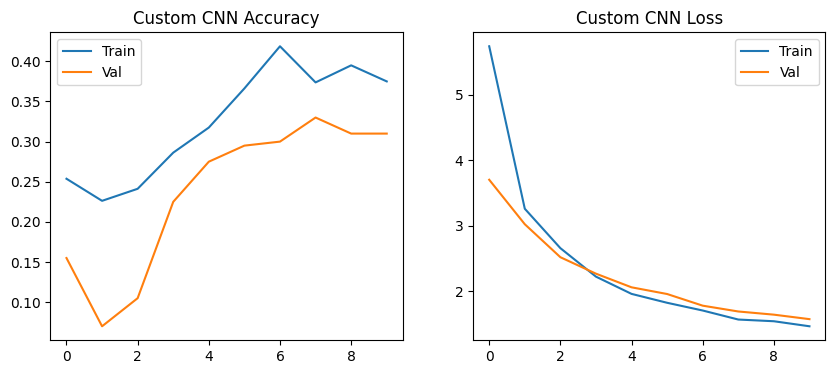


--- Custom CNN Report ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
              precision    recall  f1-score   support

       daisy       0.16      0.90      0.26        20
   dandelion       0.67      0.20      0.31       100
        rose       0.64      0.40      0.49        40
   sunflower       0.06      0.10      0.08        10
       tulip       0.54      0.23      0.33        30

    accuracy                           0.31       200
   macro avg       0.41      0.37      0.29       200
weighted avg       0.56      0.31      0.33       200



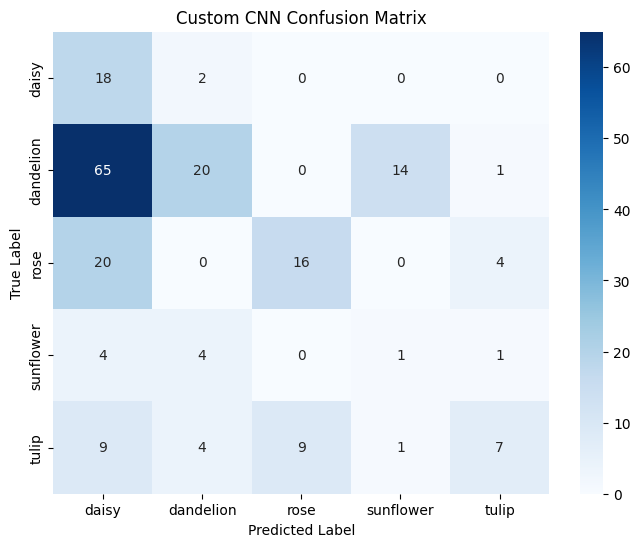

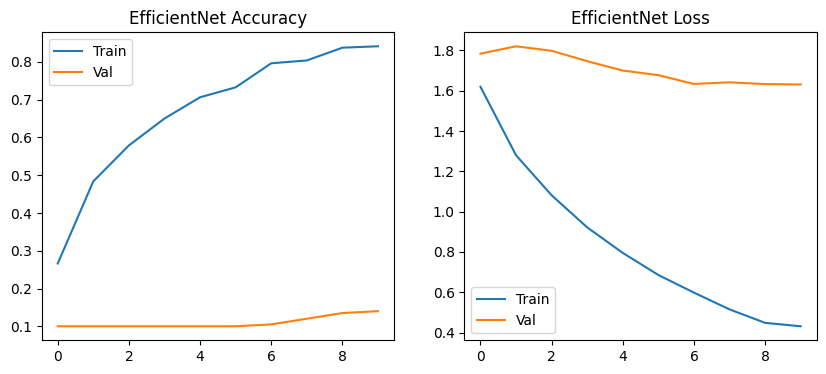


--- EfficientNet Report ---
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
              precision    recall  f1-score   support

       daisy       0.07      0.60      0.13        20
   dandelion       0.59      0.16      0.25       100
        rose       0.00      0.00      0.00        40
   sunflower       0.00      0.00      0.00        10
       tulip       0.00      0.00      0.00        30

    accuracy                           0.14       200
   macro avg       0.13      0.15      0.08       200
weighted avg       0.30      0.14      0.14       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


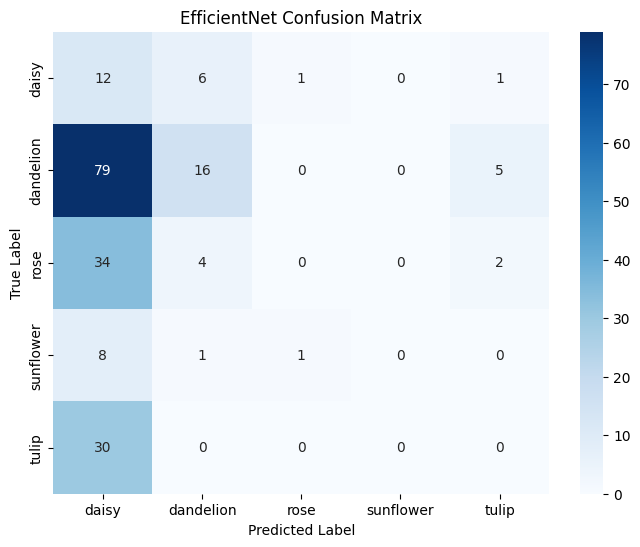

Generating t-SNE Visualization...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


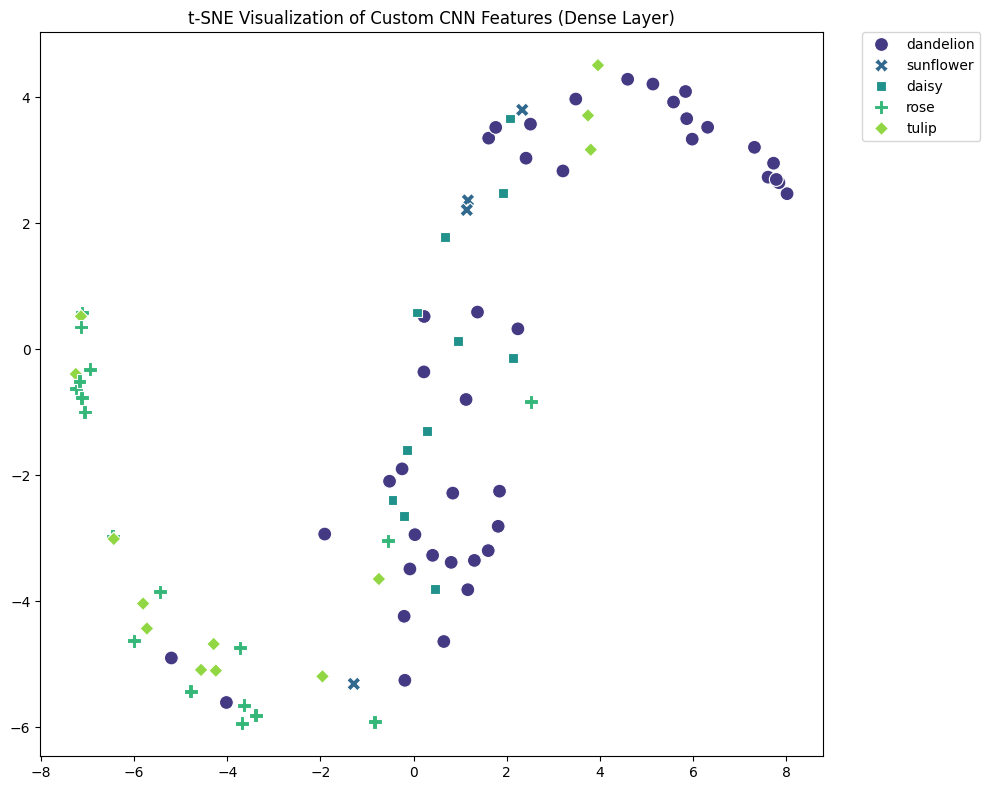

In [ ]:
def plot_metrics(history, title):
    # Check if history exists to avoid errors if training failed
    if not history:
        print(f"No history found for {title}")
        return

    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train')
    plt.plot(val_acc, label='Val')
    plt.title(f'{title} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train')
    plt.plot(val_loss, label='Val')
    plt.title(f'{title} Loss')
    plt.legend()
    plt.show()

def evaluate_model(model, generator, title):
    print(f"\n--- {title} Report ---")
    
    # Reset generator to start to ensure order matches labels
    generator.reset()
    
    # Predict
    y_pred_prob = model.predict(generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes
    
    # Classification Report
    print(classification_report(y_true, y_pred, target_names=list(generator.class_indices.keys())))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=generator.class_indices.keys(), 
                yticklabels=generator.class_indices.keys())
    plt.title(f'{title} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 1. Visualize Training Results
plot_metrics(history_custom, "Custom CNN")
evaluate_model(model_custom, val_gen_flowers, "Custom CNN")

plot_metrics(history_effnet, "EfficientNet")
evaluate_model(model_effnet, val_gen_flowers, "EfficientNet")

# 2. PS5: Feature Visualization (t-SNE) - Keras 3 Fixed Version
print("Generating t-SNE Visualization...")

try:
    # FIX: Instead of model.input, we create a new Sequential model 
    # using the layers from the original model up to the feature layer.
    # We slice up to -2 to get the output of the Dense(128) layer before the final classification.
    feature_extractor = models.Sequential(model_custom.layers[:-2])
    
    # Ensure the extractor is built
    feature_extractor.build((None, IMG_SIZE[0], IMG_SIZE[1], 3))
    
    # Get features (Take a subset of validation data to save time/memory)
    # We iterate manually to get a batch of images and labels
    val_gen_flowers.reset()
    X_batch, y_batch = next(val_gen_flowers) 
    # Use 2-3 batches for better visualization if memory allows
    for _ in range(2): 
        X_temp, y_temp = next(val_gen_flowers)
        X_batch = np.concatenate([X_batch, X_temp])
        y_batch = np.concatenate([y_batch, y_temp])

    # Predict features
    features = feature_extractor.predict(X_batch)
    
    # Get scalar labels for coloring
    y_labels = np.argmax(y_batch, axis=1)
    class_names = list(val_gen_flowers.class_indices.keys())
    y_names = [class_names[i] for i in y_labels]

    # Run t-SNE 
    tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(features)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=y_names, palette='viridis', style=y_names, s=100)
    plt.title("t-SNE Visualization of Custom CNN Features (Dense Layer)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Skipping t-SNE visualization due to error: {e}")


--- Transfer Learning: Flowers -> Intel Images ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
165/173 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.3478 - loss: 1.6986

2026-02-13 08:42:26.549839: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:26.683497: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:26.993660: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:27.134509: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:27.834088: E external/local_xla/xla/stream_

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3508 - loss: 1.6930

2026-02-13 08:42:56.016073: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:56.148157: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:56.451310: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:56.591061: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-13 08:42:57.277287: E external/local_xla/xla/stream_

173/173 ━━━━━━━━━━━━━━━━━━━━ 112s 537ms/step - accuracy: 0.3512 - loss: 1.6924 - val_accuracy: 0.5377 - val_loss: 1.3881
Epoch 2/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - accuracy: 0.4470 - loss: 1.4952 - val_accuracy: 0.5732 - val_loss: 1.2285
Epoch 3/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - accuracy: 0.4945 - loss: 1.3516 - val_accuracy: 0.5899 - val_loss: 1.1939
Epoch 4/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.5052 - loss: 1.3610 - val_accuracy: 0.6065 - val_loss: 1.1267
Epoch 5/5
173/173 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - accuracy: 0.5193 - loss: 1.3844 - val_accuracy: 0.5457 - val_loss: 1.2251

--- Transfer Learning (Flowers->Intel) Report ---
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step
              precision    recall  f1-score   support

   buildings       0.45      0.33      0.38        60
      forest       0.80      0.89      0.84       400
     glacier       0.16      0.60      0.25        60
    mountain       0.72      0.07      0.12      

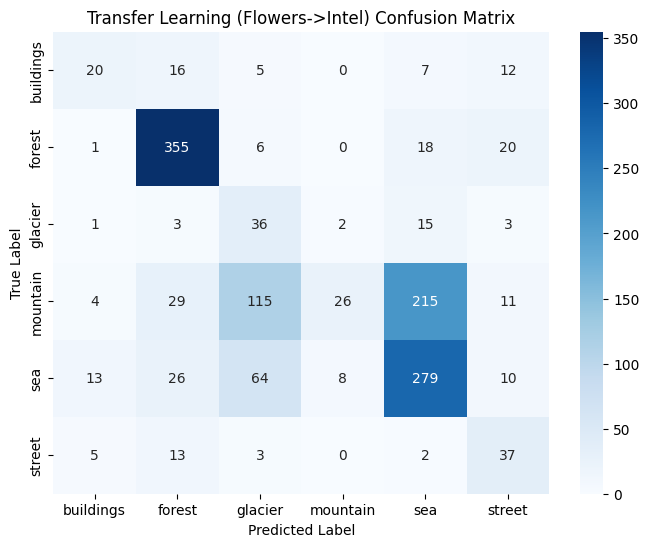

In [9]:
print("\n--- Transfer Learning: Flowers -> Intel Images ---")

# 1. Modify the trained EfficientNet top layer for Intel classes
# Pop the last layer (Softmax for Flowers)
input_layer = model_effnet.input
output_layer = model_effnet.layers[-2].output # Get output before final dense
new_output = layers.Dense(len(intel_classes), activation='softmax', name='intel_output')(output_layer)

model_transfer = models.Model(inputs=input_layer, outputs=new_output)

# 2. Freeze base layers to keep Flower knowledge initially
for layer in model_transfer.layers[:-5]:
    layer.trainable = False

model_transfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Train on Intel Data
intel_weights = get_class_weights(train_gen_intel)

history_transfer = model_transfer.fit(
    train_gen_intel,
    epochs=5, # Short training to adapt
    validation_data=val_gen_intel,
    class_weight=intel_weights
)

evaluate_model(model_transfer, val_gen_intel, "Transfer Learning (Flowers->Intel)")